# [Object Detection using PyTorch Faster R-CNN MobileNetV3](https://debuggercafe.com/object-detection-using-pytorch-faster-r-cnn-mobilenetv3)
![](https://debuggercafe.com/wp-content/uploads/2021/03/Object-Detection-using-PyTorch-Faster-R-CNN-MobileNetV3-copy-e1617153888534.jpg)

In [1]:
import torchvision
import cv2

In [ ]:
# remove the last two layers, now have 91 classes and 91*4 bounding bax

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import random
from PIL import Image, ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [4]:
from google.colab.patches import cv2_imshow

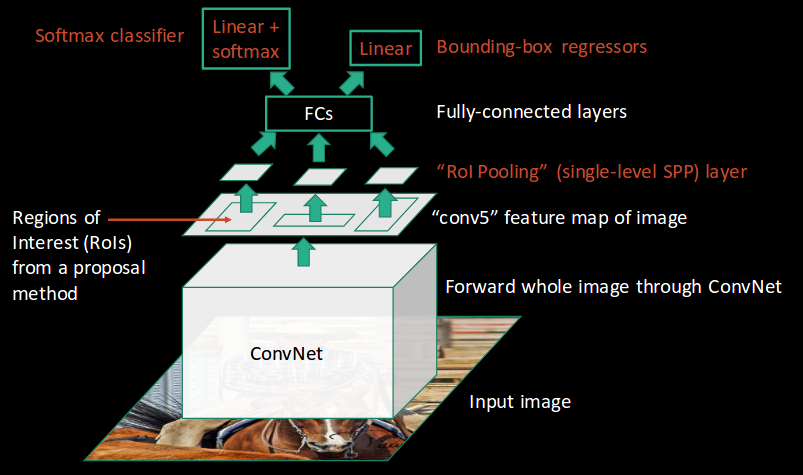

## R-CNN

R-CNN involves the following steps:

1. Extracting regions from an image using selective search.
2. Checking each region for containing an object.
3. Using CNN to extract specific features for each region.
4. Detecting objects based on the extracted features.

This multi-step process makes R-CNN slow.

## Fast R-CNN

Fast R-CNN improves speed by:

1. Passing the entire image to a ConvNet to generate regions of interest.
2. Using a single model for feature extraction, classification, and bounding box prediction simultaneously.
3. Despite being faster than R-CNN, it still relies on selective search for region extraction, limiting its speed on large datasets.

## Faster R-CNN

Faster R-CNN addresses speed issues by:

1. Extracting feature maps from the input image using ConvNet.
2. Using a Region Proposal Network (RPN) to replace selective search for efficient region proposal generation.
3. Classifying and predicting bounding boxes based on the generated proposals.

This approach significantly improves the speed of object detection compared to R-CNN and Fast R-CNN.


In [5]:
 model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 121MB/s]


## Two-Stage Training Overview

The training process involves two stages. The first stage focuses on predicting bounding box coordinates, while the second stage is dedicated to labeling objects in the image. The current pretrained model is trained on the Coco dataset.

## Model Architecture

### Classification Head (`cls_score`)

- **Type:** Linear layer
- **Input Features:** 1024
- **Output Features:** 91 (corresponding to the total number of classes in the Coco dataset)
- **Bias:** True

### Bounding Box Regression Head (`bbox_pred`)

- **Type:** Linear layer
- **Input Features:** 1024
- **Output Features:** 364 (4 positions for each bounding box)
- **Bias:** True

## Loss Function

The loss function used is a combination of two components:

### 1. Localization Loss (Bounding Box Regression)

- Utilizes the smooth L1 loss for bounding box regression.
- Smooth L1 loss provides a differentiable and less outlier-sensitive alternative to traditional L1 loss.
- Applied only to positive (foreground) region proposals.


### 2. Classification Loss

- Computed using softmax cross-entropy.
- Involves predicted class scores \( p \) and ground truth class labels.
- The model is trained to minimize this classification loss.

## Class Label Consideration

In the Coco dataset update, there are 91 features in total, explaining the output features of the classification head. The Bounding Box Regression Head has 364 features due to the nature of bounding boxes (4 positions for each box). This two-stage training approach allows the model to effectively predict object classes and localize them within images.


In [6]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io

# Set the API credentials JSON file path
credentials_file_path = 'path/to/credentials.json'

# Set the ID of the target file in Google Drive
target_file_id = 'your_target_file_id'

# Scopes required for the Google Drive API
scopes = ['https://www.googleapis.com/auth/drive.readonly']

def authenticate():
    flow = InstalledAppFlow.from_client_secrets_file(credentials_file_path, scopes)
    credentials = flow.run_local_server(port=0)
    return credentials

def download_file(service, file_id, file_name):
    request = service.files().get_media(fileId=file_id)
    fh = io.FileIO(file_name, 'wb')
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Download {int(status.progress() * 100)}%")

In [8]:
coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" ,
"frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" ,
"baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" ,
"plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" ,
"banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" ,
"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,
"mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" ,
"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,
"oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,
"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]

In [9]:
def showOneExample(ig): # find out the highest probability object detected
  transform = transforms.ToTensor()
  img = transform(ig)
  with torch.no_grad():
    pred = model([img])
    boxes, labels, scores = pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]
    # get the score over 80 percent
    print(scores)
    index_high_prob = torch.argwhere(scores>0.9)
    number_index_high_prob = index_high_prob.shape[0]
  return number_index_high_prob,boxes[:number_index_high_prob],labels[:number_index_high_prob]

In [10]:
import os
import random

file_path = '/content/drive/MyDrive/dataCoco/coco2017_val/val2017/val2017'

# List only file names in the directory
file_names = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]

# Choose a random file name
random_file_name = random.choice(file_names)

# Print the randomly chosen file name
print("Randomly chosen file name:", random_file_name)

FileNotFoundError: ignored

In [ ]:
current_path = os.getcwd()
coco_random_download = os.path.join(current_path, 'Coco', 'randomSample')
print("Current Path:", current_path)
print("coco random download path: ",coco_random_download)
# get one random picture from the coco dataset
def getOneCoco():
  random_img_id = "000000000872"
  # Generate the URL for the chosen image ID
  image_url=f"http://images.cocodataset.org/val2017/{random_img_id}.jpg"
  print("random iamge url:" + image_url)

  !wget "$image_url" -P "$coco_random_download"

  # Use wget command to download the randomly selected image to the specified location
  #os.system(f"wget {image_url} -P {coco_random_download}")
  return random_img_id
current_img = getOneCoco()


In [ ]:
#  read img and predict
font = cv2.FONT_HERSHEY_PLAIN
def read_img_predict(igDir):
  read_img_dir = os.path.join(coco_random_download, igDir+".jpg")
  print(read_img_dir)
  ig = Image.open(read_img_dir)
  number_index_high_prob,boxes,labels = showOneExample(ig)
  # print(number_index_high_prob)
  # print(boxes)
  ig_cv = cv2.imread(read_img_dir)
  for i in range(number_index_high_prob):
    # coordinates have to be integer; slight error
    x1,y1,x2,y2 = boxes[i].numpy().astype("int")
    print(x1,y1,x2,y2)
    className = coco_names[labels.numpy()[i]-1]
    # create boundxing box blue color, thickness as 1
    ig_cv = cv2.rectangle(ig_cv,(x1,y1),(x2,y2),(255,0,0),1)
    # put the label above the bounding box,
    # font size of 0.5, font as cv2.FONT_HERSHEY_PLAIN, green, thickness 1
    ig_cv = cv2.putText(ig_cv,className, (x1,y1-10), font,1 , (0,255,0), 1, cv2.LINE_AA)
  cv2_imshow(ig_cv)

read_img_predict(current_img)